## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py
import numpy as np
import scipy as sp
import skimage as ski
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import cm
from ipywidgets import interact
from scipy.optimize import curve_fit
from matplotlib import patches
from matplotlib.colors import hsv_to_rgb, LinearSegmentedColormap
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from skimage.metrics import peak_signal_noise_ratio as psnr

from fusion import FusionAdam, FusionCG
from baseline import baseline
from utils import mono_exponential_decay_numpy as decay
from utils import (
    RESOURCES_PATH,
    FIGURES_PATH,
    spectral_volume_to_color,
    time_volume_to_lifetime,
    preprocess_raw_spc,
    linear_to_srgb,
    wavelength_to_srgb,
    sam,
    rmse,
)

XY_DIM = 128
Z_START = 2
Z_END = -4

KIDNEY2_PATH = RESOURCES_PATH / "kidney2"
SPC_PATH = KIDNEY2_PATH / "520_kidney2_550_550_610_SPC_calib_cut_binned_tlxy.npz"
SPC_ZOOMED_PATH = KIDNEY2_PATH / "520_kidney2_128_550_550_610_SPC_calib_cut_binned_tlxy.npz"
CMOS_PATH = KIDNEY2_PATH / "kidney2_520_4m_rec_FOVcorrected.mat"
LAMBDA_PATH = KIDNEY2_PATH / "610_Lambda_L16.mat"

TAU = r"$\tau$"

PREPROCESS = False

/Users/cris/PycharmProjects/datafusion/fusion.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## SPC preprocessing

In [3]:
if PREPROCESS:
    from scipy.linalg import lstsq
    from utils import TVAL3

    tval = TVAL3(img_shape=(32, 32))

    N_MEASUREMENTS = 1024
    MAX_TIMES = 2048
    N_BINS = 32

    # Preprocess SPC
    preprocess_raw_spc(
        raw_spc_path=KIDNEY2_PATH / "520_kidney2_550_550_610_SPC_raw.mat",
        reconstruction_save_path=SPC_PATH,
        forward_matrix_path=KIDNEY2_PATH / "FLIM_Scrambled-Hadamard_1024.mat",
        efficiency_calib_path=KIDNEY2_PATH / "Efficiency_L16_610.mat",
        offset_calib_path=KIDNEY2_PATH / "L16_temporal_offsets_20220520.mat",
        temporal_axis_path=KIDNEY2_PATH / "t.npy",
        n_measurements=N_MEASUREMENTS,
        max_times=MAX_TIMES,
        algo=tval,
        compression=0.7,
        n_bins=N_BINS,
        n_jobs=1,  # TVAL3 uses the MATLAB engine, please use 1 job to avoid problems.
        dtype=np.float32,
    )

    # Preprocess zoomed SPC
    preprocess_raw_spc(
        raw_spc_path=KIDNEY2_PATH / "520_kidney2_128_550_550_610_SPC_raw.mat",
        reconstruction_save_path=SPC_ZOOMED_PATH,
        forward_matrix_path=KIDNEY2_PATH / "FLIM_Scrambled-Hadamard_1024.mat",
        efficiency_calib_path=KIDNEY2_PATH / "Efficiency_L16_610.mat",
        offset_calib_path=KIDNEY2_PATH / "L16_temporal_offsets_20220520.mat",
        temporal_axis_path=KIDNEY2_PATH / "t.npy",
        n_measurements=N_MEASUREMENTS,
        max_times=MAX_TIMES,
        n_bins=N_BINS,
        algo=lstsq,
        n_jobs=8,
        dtype=np.float32,
    )

## Data loading

In [5]:
# CMOS loading
with h5py.File(CMOS_PATH, "r") as f:
    cmos = np.array(f["I"])
    cmos = np.transpose(cmos, (1, 2, 0))
    cmos = ski.transform.resize(cmos, (XY_DIM, XY_DIM, cmos.shape[2]))
    cmos = np.transpose(cmos, (2, 1, 0))
    cmos = cmos[Z_START:Z_END]

# SPC loading
# If you are not using the preprocessing in python, redefine the paths to the files here.
# SPC_PATH = RESOURCES_PATH / "kidney2" / "520_kidney2_550_550_610_SPC_raw_proc_tlxy_bin200ps_cut.mat"
SPC_PATH = RESOURCES_PATH / "kidney2" / "TVAL3" / "520_kidney2_550_550_610_SPC_raw_proc_tlxy_bin200ps_cut_CR50_b5m8.mat"
SPC_ZOOMED_PATH = RESOURCES_PATH / "kidney2" / "520_kidney2_128_550_550_610_SPC_raw_proc_tlxy_bin200ps_cut.mat"
spc = sp.io.loadmat(SPC_PATH)["im"]
gt_spc = sp.io.loadmat(SPC_ZOOMED_PATH)["im"]

# spc = np.load(SPC_PATH)["spc_recon"] # .swapaxes(-2, -1)
# gt_spc = np.load(SPC_ZOOMED_PATH)["spc_recon"].swapaxes(-2, -1)
# FIXME: Replace with correct [0,0] pixel.
gt_spc[:, :, 0, 0] = gt_spc[:, :, 1, 0]
spc[:, :, 0, 0] = spc[:, :, 1, 0]

# Time axis loading
t = np.squeeze(sp.io.loadmat(SPC_ZOOMED_PATH)["t"])
# t = np.load(SPC_PATH)["t_cut_binned"]
t = t - t.min()
dt = t[1] - t[0]

# Wavelength axis loading
lam = np.squeeze(sp.io.loadmat(LAMBDA_PATH)["lambda"])

# Normalization for plotting
cmos_max = cmos / cmos.max()
spc_max = spc / spc.max()
gt_spc_max = gt_spc / gt_spc.max()

cmos.shape, spc.shape

((20, 128, 128), (77, 16, 32, 32))

## Data exploration

In [6]:
initial_spectrums = np.sum(spc, axis=0)
min_spectrums, max_spectrums = np.min(initial_spectrums), np.max(initial_spectrums)

initial_times = np.sum(spc, axis=1)
min_times, max_times = np.min(initial_times), np.max(initial_times)

resolution_diff_factor = int(cmos.shape[-1] / spc.shape[-1])


def spc_spectrum_time_in_a_point(cmos_z=5, spc_i=19, spc_j=17):
    _, ax = plt.subplots(2, 3, figsize=(9, 6))
    ax[0, 0].imshow(cmos_max[cmos_z], cmap="gray", vmin=0, vmax=1)
    ax[0, 0].scatter([spc_j * resolution_diff_factor], [spc_i * resolution_diff_factor], c="w")
    ax[0, 0].set_title(f"CMOS in Z={cmos_z}")

    ax[1, 0].imshow(spectral_volume_to_color(lam, spc.sum(axis=0)[:, np.newaxis])[0])
    ax[1, 0].scatter([spc_j], [spc_i], c="w")
    ax[1, 0].set_title(f"SPC Spectrum Colored")

    ax[0, 1].plot(lam, spc.sum(axis=(0, 2, 3)))
    ax[0, 1].set_title(f"Global spectrum - {len(lam)} channels")
    ax[0, 1].set_xlabel("Wavelength [nm]")
    ax[0, 1].grid()

    ax[0, 2].plot(t, spc.sum(axis=(1, 2, 3)))
    ax[0, 2].set_title(f"Global time decay - {len(t)} temporal points")
    ax[0, 2].set_xlabel("Time [ns]")
    ax[0, 2].grid()

    ax[1, 1].plot(lam, initial_spectrums[:, spc_i, spc_j])
    ax[1, 1].set_ylim(min_spectrums, max_spectrums)
    ax[1, 1].set_title(f"Spectrum in ({spc_i},{spc_j})")
    ax[1, 1].set_xlabel("Wavelength [nm]")
    ax[1, 1].grid()

    ax[1, 2].plot(t, initial_times[:, spc_i, spc_j])
    ax[1, 2].set_ylim(min_times, max_times)
    ax[1, 2].set_title(f"Time in ({spc_i},{spc_j})")
    ax[1, 2].set_xlabel("Time [ns]")
    ax[1, 2].grid()

    plt.tight_layout()
    plt.show()


interact(
    spc_spectrum_time_in_a_point,
    cmos_z=(0, cmos.shape[0] - 1, 1),
    spc_i=(0, spc.shape[-2] - 1, 1),
    spc_j=(0, spc.shape[-1] - 1, 1),
);

interactive(children=(IntSlider(value=5, description='cmos_z', max=19), IntSlider(value=19, description='spc_i…

In [7]:
weights = {
    "spatial": 0.5,
    "lambda_time": 0.5,
    # "global": 0.0,
}

## Fusion through optimizatio with Adam

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

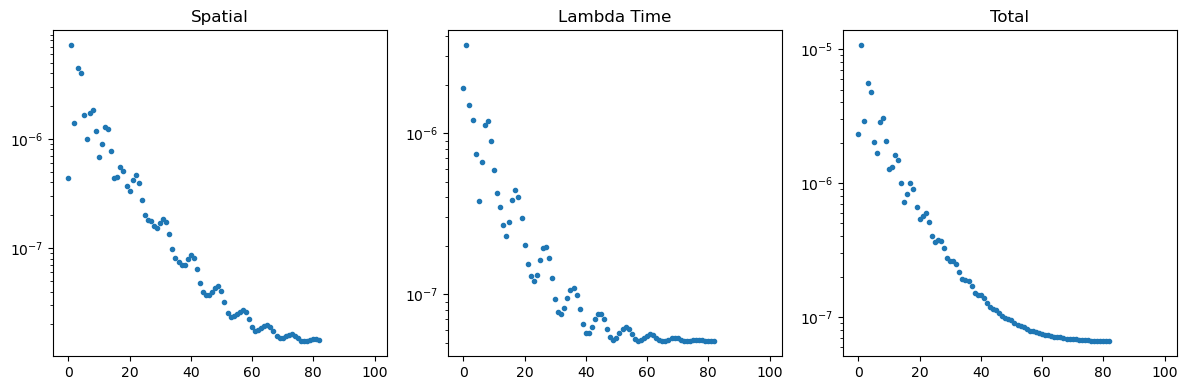

In [8]:
fuse_with_adam = FusionAdam(
    spc, cmos, weights=weights, init_type="baseline", mask_noise=False, tol=1e-6, total_energy=1, device="cpu", seed=42,
)
x, spc_out, cmos_out = fuse_with_adam(iterations=100, lr=1e-8, return_numpy=True)

## Fusion through optimization with Conjugate Gradient

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

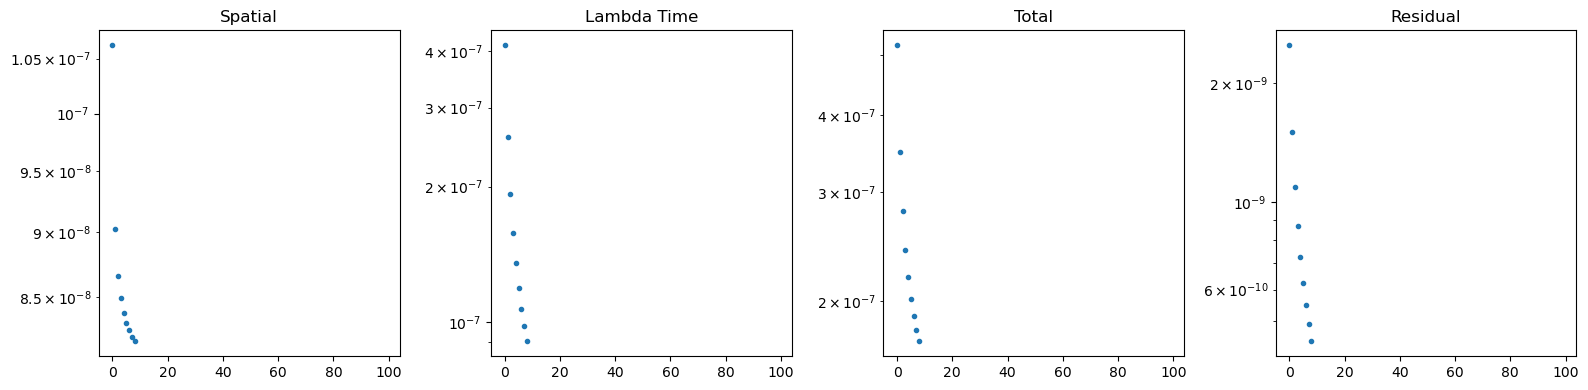

In [11]:
fuse_with_cg = FusionCG(
    spc, cmos, weights=weights, init_type="baseline", tol=1e-6, mask_noise=False, total_energy=1, device="cpu", seed=42,
)
x_cg, spc_out, cmos_out = fuse_with_cg(iterations=100, eps=1e-8, return_numpy=True)

In [80]:
loss_adam_space, loss_adam_lambda_time = fuse_with_adam.loss()
loss_cg_space, loss_cg_lambda_time = fuse_with_cg.loss()
print(f"F(x_adam): Space: {loss_adam_space:.2E}, LambdaTime: {loss_adam_lambda_time:.2E}")
print(f"F(x_cg): Space: {loss_cg_space:.2E}, LambdaTime: {loss_cg_lambda_time:.2E}")

F(x_adam): Space: 1.35E-08, LambdaTime: 5.19E-08
F(x_cg): Space: 8.14E-08, LambdaTime: 8.43E-08


In [ ]:
print(x.sum(), cmos_out.sum(), spc_out.sum())
print(x_cg.sum(), cmos_out.sum(), spc_out.sum())

## Fusion through baseline

In [ ]:
x_baseline = baseline(cmos_out, spc_out, device="cpu", return_numpy=True)

## Get spectral and lifetime volumes

In [ ]:
intensity_volume = x.sum(axis=(0, 1))
intensity_volume /= intensity_volume.max()
spectral_volume = spectral_volume_to_color(lam, x.sum(axis=0))
lifetime_volume, tau_min, tau_max = time_volume_to_lifetime(
    t, x.sum(axis=1), tau_clip=(1, 3), noise_thr=0.1
)

## Visualize results

In [9]:
slices_rgb = spectral_volume_to_color(lam, np.sum(x, axis=0))
slices_rgb_spc = spectral_volume_to_color(lam, spc_out[:, :, np.newaxis, :, :].sum(axis=0))[0]

spectrums = np.sum(x, axis=(0, 3, 4)).T
times = np.sum(x, axis=(1, 3, 4)).T


def plot_across_z(z=10, i=80, j=70):
    _, ax = plt.subplots(2, 3, figsize=(12, 8))
    ax[0, 0].imshow(slices_rgb_spc)
    ax[0, 0].scatter([j // 4], [i // 4], c="w")
    ax[0, 0].set_title(f"SPC")

    ax[1, 1].plot(lam, spectrums[z])
    ax[1, 1].set_ylim(spectrums.min(), spectrums.max())
    ax[1, 1].set_title(f"Global Spectrum in z={z}")
    ax[1, 1].grid()

    ax[1, 2].plot(t, times[z])
    ax[1, 2].set_ylim(times.min(), times.max())
    ax[1, 2].set_title(f"Global Time in z={z}")
    ax[1, 2].grid()

    reconstructed_spectrums = np.sum(x[:, :, z, :, :], axis=0)
    lxy_spc = np.sum(spc_out, axis=0)

    reconstructed_times = np.sum(x[:, :, z, :, :], axis=1)
    txy_spc = np.sum(spc_out, axis=1)

    ax[1, 0].imshow(slices_rgb[z])
    ax[1, 0].scatter([j], [i], c="w")
    ax[1, 0].set_title(f"Reconstruction Spectral Colored z={z}")

    ax[0, 1].plot(lam, reconstructed_spectrums[:, i, j] * 10 * 16, label="DF")
    ax[0, 1].plot(lam, lxy_spc[:, i // 4, j // 4], label="SPC")
    ax[0, 1].set_title(f"Spectrum in ({i},{j})")
    ax[0, 1].legend(loc="upper right")
    ax[0, 1].grid()

    params, covariance = curve_fit(
        decay,
        t,
        reconstructed_times[:, i, j] / reconstructed_times[:, i, j].max(),
        bounds=([0.0, 1e-6, 0.0], [1, 6.0, 0.1]),
        p0=(0.5, 2.0, 0.00001),
        maxfev=5000,
    )
    a, tau, c = params

    ax[0, 2].plot(t, txy_spc[:, i // 4, j // 4] / txy_spc[:, i // 4, j // 4].max(), label="SPC", c="C1")
    ax[0, 2].scatter(t, reconstructed_times[:, i, j] / reconstructed_times[:, i, j].max(), label="DF", c="C0",
                     marker="+")
    ax[0, 2].plot(t, decay(t, a, tau, c), label=f"DF Fit {TAU}: {tau:.2f} ns", c="C0")
    ax[0, 2].set_title(f"Time in ({i},{j})")
    ax[0, 2].legend(loc="upper right")
    ax[0, 2].grid()

    plt.tight_layout()
    plt.show()


interact(
    plot_across_z,
    z=(0, x.shape[2] - 1, 1),
    i=(0, x.shape[-2] - 1, 1),
    j=(0, x.shape[-1] - 1, 1),
);

interactive(children=(IntSlider(value=10, description='z', max=19), IntSlider(value=80, description='i', max=1…


## Plot results

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

SAM: 0.19 rad


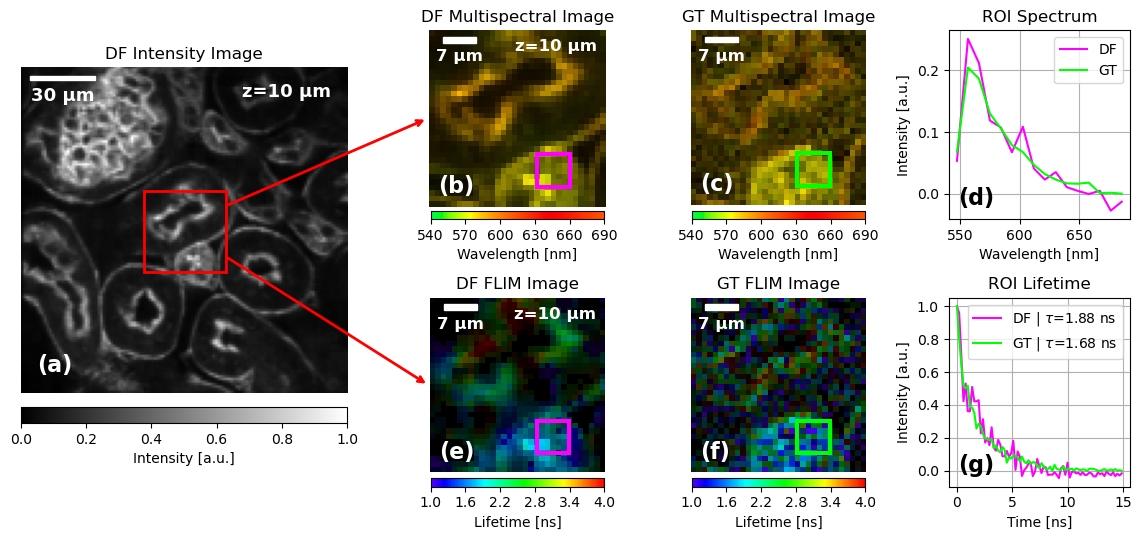

In [11]:
def add_z_text(z_index, ax, font_size=12):
    ax.text(
        0.95, 0.95, f"z={z_index} µm",
        transform=ax.transAxes,
        fontsize=font_size,
        fontweight="bold",
        va="top",
        ha="right",
        c="w"
    )


def plot_zoom_results(
        x, t, lam,
        gt_spc,
        z_index,
        zoom_slice=slice(48, 80),
        roi_u=slice(24, 30),
        roi_v=slice(19, 25),
        font_size_letters=16,
        tau_clip=(0, 4),
        save_name=None,
):
    # Defining spectral colorbar
    wavelengths_ticks = np.arange(540, 691, 1)
    spectral_colors = wavelength_to_srgb(wavelengths_ticks, "basic").T
    spectral_colors = linear_to_srgb(spectral_colors)
    spectral_colors /= spectral_colors.max(axis=1)[..., np.newaxis]
    spectral_cmap = LinearSegmentedColormap.from_list("spectrum", spectral_colors, N=len(wavelengths_ticks))

    # Defining fused scalebar
    fused_micro_width = 150  # in micrometers
    pixel_size = fused_micro_width / x.shape[-1]
    scalebar_length_micrometers = 30
    scalebar_length_pixels = scalebar_length_micrometers / pixel_size

    # Defining zoomed scalebar
    zoomed_micro_width = 150 / (x.shape[-1] / gt_spc.shape[-1])
    pixel_size = zoomed_micro_width / gt_spc.shape[-1]
    scalebar_length_micrometers_zoomed = 7
    scalebar_length_pixels_zoomed = scalebar_length_micrometers_zoomed / pixel_size

    fused_intensity = x.sum(axis=(0, 1))[z_index]

    # Defining the fused zoomed tensors
    fused_zoomed = x[:, :, z_index:z_index + 1, zoom_slice, zoom_slice]
    fused_zoomed_spectral = spectral_volume_to_color(lam, fused_zoomed.sum(axis=0))[0]
    fused_lifetime_image = time_volume_to_lifetime(
        t, fused_zoomed.sum(axis=1), tau_clip=tau_clip, noise_thr=0.1
    )[0][0]

    # Defining the ground truth zoomed tensors
    gt_spc_spectral = spectral_volume_to_color(lam, gt_spc.sum(axis=0)[:, np.newaxis])[0]
    ground_truth_lifetime_image = time_volume_to_lifetime(
        t, gt_spc.sum(axis=1, keepdims=True), tau_clip=tau_clip, noise_thr=0.1
    )[0][0]

    # fused_zoomed_time_wavelength = fused_zoomed.sum(axis=(2, 3))[:, :, 0]
    # gt_time_wavelength = gt_spc.sum(axis=(2, 3))
    # psnr_time_wavelength = psnr(gt_time_wavelength, fused_zoomed_time_wavelength,
    #                             data_range=gt_time_wavelength.max() - gt_time_wavelength.min())
    # print(f"PSNR time-wavelength: {psnr_time_wavelength:.2f} dB")

    fig = plt.figure(figsize=(11.5, 5.5))
    gs = fig.add_gridspec(2, 4, width_ratios=[1.8, 1, 1, 1], height_ratios=[1, 1])

    # Plot fused intensity
    ax0 = fig.add_subplot(gs[:, 0])
    fused_0 = ax0.imshow(fused_intensity / fused_intensity.max(), cmap='gray')
    ax0.set_title(f"DF Intensity Image")
    ax0.add_patch(patches.Rectangle(
        (zoom_slice.start, zoom_slice.start),
        zoom_slice.stop - zoom_slice.start,
        zoom_slice.stop - zoom_slice.start,
        linewidth=2, edgecolor='red', facecolor='none')
    )
    ax0.text(0.05, 0.05, "(a)", transform=ax0.transAxes, fontsize=font_size_letters, fontweight='bold', va='bottom',
             c="w")
    scalebar = AnchoredSizeBar(
        ax0.transData,
        scalebar_length_pixels,  # Length of scalebar in pixels
        f'{scalebar_length_micrometers} µm',  # Label for the scalebar
        'upper left',
        pad=0.4,
        sep=5,
        color='white',
        frameon=False,
        size_vertical=1.5,
        fontproperties={"size": 13, "weight": "bold"},
    )
    ax0.add_artist(scalebar)
    add_z_text(z_index, ax0, font_size=13)

    # ax0.text(
    #     0.48, 0.06, f"PSNR: {psnr_intensity:.2f} dB",
    #     transform=ax0.transAxes,
    #     fontsize=12,
    #     va="top",
    #     color="white",
    #     fontweight="bold",
    # )

    ax0.axis("off")

    # Spectral comparison
    ax01 = fig.add_subplot(gs[0, 1])
    zoom01 = ax01.imshow(fused_zoomed_spectral, cmap=spectral_cmap)
    ax01.set_title(f"DF Multispectral Image")
    ax01.text(0.05, 0.05, "(b)", transform=ax01.transAxes, fontsize=font_size_letters,
              fontweight='bold', va='bottom', c="w")
    ax01.add_patch(patches.Rectangle(
        (roi_v.start, roi_u.start),
        roi_v.stop - roi_v.start,
        roi_u.stop - roi_u.start,
        linewidth=3, edgecolor="magenta", facecolor='none')
    )
    scalebar = AnchoredSizeBar(
        ax01.transData,
        scalebar_length_pixels_zoomed,  # Length of scalebar in pixels
        f'{scalebar_length_micrometers_zoomed} µm',  # Label for the scalebar
        'upper left',
        pad=0.3,
        sep=5,
        color='white',
        frameon=False,
        size_vertical=1,
        fontproperties={"size": 12, "weight": "bold"},
    )
    ax01.add_artist(scalebar)
    add_z_text(z_index, ax01, font_size=12)

    # Add PSNR with respect to the ground truth
    # psnr_spectrum = np.zeros(gt_spc.shape[1])
    # for i in range(gt_spc.shape[1]):
    #     gt_tmp = gt_spc.sum(axis=0)[i]
    #     fused_tmp = fused_zoomed.sum(axis=0)[i, 0]
    #     psnr_spectrum[i] = psnr(
    #         gt_tmp,
    #         fused_tmp,
    #         data_range=gt_tmp.max() - gt_tmp.min(),
    #     )
    # print(psnr(gt_spc.sum(axis=(0, 1)), fused_zoomed.sum(axis=(0, 1))[0],
    #            data_range=gt_spc.sum(axis=(0, 1)).max() - gt_spc.sum(axis=(0, 1)).min()))
    # psnr_lifetime = np.mean(psnr_spectrum)
    # ax01.text(
    #     0.26, 0.08, f"PSNR: {psnr_lifetime:.2f} dB",
    #     transform=ax01.transAxes,
    #     fontsize=10,
    #     va="top",
    #     color="white",
    #     fontweight="bold",
    # )
    ax01.axis("off")

    ax02 = fig.add_subplot(gs[0, 2])
    zoom02 = ax02.imshow(gt_spc_spectral, cmap=spectral_cmap)
    ax02.set_title(f"GT Multispectral Image")
    ax02.text(0.05, 0.05, "(c)", transform=ax02.transAxes, fontsize=font_size_letters, fontweight='bold', va='bottom',
              c="w")
    ax02.add_patch(patches.Rectangle(
        (roi_v.start, roi_u.start),
        roi_v.stop - roi_v.start,
        roi_u.stop - roi_u.start,
        linewidth=3, edgecolor="lime", facecolor='none')
    )
    scalebar = AnchoredSizeBar(
        ax02.transData,
        scalebar_length_pixels_zoomed,  # Length of scalebar in pixels
        f'{scalebar_length_micrometers_zoomed} µm',  # Label for the scalebar
        'upper left',
        pad=0.3,
        sep=5,
        color='white',
        frameon=False,
        size_vertical=1,
        fontproperties={"size": 12, "weight": "bold"},
    )
    ax02.add_artist(scalebar)
    ax02.axis("off")

    ax03 = fig.add_subplot(gs[0, 3])
    fused_roi_spectrum = fused_zoomed[:, :, 0, roi_u, roi_v].sum(axis=(0, 2, 3))
    fused_roi_spectrum /= fused_roi_spectrum.sum()
    ax03.plot(lam, fused_roi_spectrum, label="DF", c="magenta")
    spc_roi_spectrum = gt_spc[:, :, roi_u, roi_v].sum(axis=(0, 2, 3))
    spc_roi_spectrum /= spc_roi_spectrum.sum()
    ax03.plot(lam, spc_roi_spectrum, label="GT", c="lime")
    ax03.set_title("ROI Spectrum")
    ax03.set_xlabel("Wavelength [nm]")
    ax03.set_ylabel("Intensity [a.u.]")
    ax03.legend()
    ax03.grid()
    ax03.text(0.05, 0.05, "(d)", transform=ax03.transAxes, fontsize=font_size_letters, fontweight="bold", va='bottom')
    print(f"SAM: {sam(fused_roi_spectrum, spc_roi_spectrum):.2F} rad")

    # Lifetime comparison
    hsv_colormap = np.vstack([np.linspace(0, 26 / 36, 100)[::-1], np.ones(100), np.ones(100)]).T
    lifetime_cmap = LinearSegmentedColormap.from_list("fused_lifetime", hsv_to_rgb(hsv_colormap), N=100)

    ax11 = fig.add_subplot(gs[1, 1])
    zoom11 = ax11.imshow(fused_lifetime_image, cmap=lifetime_cmap)
    ax11.set_title(f"DF FLIM Image")
    ax11.text(0.05, 0.05, "(e)", transform=ax11.transAxes, fontsize=font_size_letters, fontweight="bold", va="bottom",
              c="w")
    ax11.add_patch(patches.Rectangle(
        (roi_v.start, roi_u.start),
        roi_v.stop - roi_v.start,
        roi_u.stop - roi_u.start,
        linewidth=3, edgecolor="magenta", facecolor='none'))
    scalebar = AnchoredSizeBar(
        ax11.transData,
        scalebar_length_pixels_zoomed,  # Length of scalebar in pixels
        f'{scalebar_length_micrometers_zoomed} µm',  # Label for the scalebar
        'upper left',
        pad=0.3,
        sep=5,
        color='white',
        frameon=False,
        size_vertical=1,
        fontproperties={"size": 12, "weight": "bold"},
    )
    ax11.add_artist(scalebar)
    add_z_text(z_index, ax11, font_size=12)

    # Add PSNR with respect to the ground truth
    # psnr_lifetime = psnr(gt_spc_tau, fused_zoomed_tau, data_range=gt_spc_tau.max() - gt_spc_tau.min())
    # ax11.text(
    #     0.26, 0.08, f"PSNR: {psnr_lifetime:.2f} dB",
    #     transform=ax11.transAxes,
    #     fontsize=10,
    #     va="top",
    #     color="white",
    #     fontweight="bold",
    # )

    ax11.axis("off")

    ax12 = fig.add_subplot(gs[1, 2])
    zoom12 = ax12.imshow(ground_truth_lifetime_image, cmap=lifetime_cmap)
    ax12.set_title(f"GT FLIM Image")
    ax12.text(0.05, 0.05, "(f)", transform=ax12.transAxes, fontsize=font_size_letters, fontweight="bold", va="bottom",
              c="w")
    ax12.add_patch(patches.Rectangle(
        (roi_v.start, roi_u.start),
        roi_v.stop - roi_v.start,
        roi_u.stop - roi_u.start,
        linewidth=3, edgecolor="lime", facecolor='none'))
    scalebar = AnchoredSizeBar(
        ax12.transData,
        scalebar_length_pixels_zoomed,  # Length of scalebar in pixels
        f'{scalebar_length_micrometers_zoomed} µm',  # Label for the scalebar
        'upper left',
        pad=0.3,
        sep=5,
        color='white',
        frameon=False,
        size_vertical=1,
        fontproperties={"size": 12, "weight": "bold"},
    )
    ax12.add_artist(scalebar)
    ax12.axis("off")

    ax13 = fig.add_subplot(gs[1, 3])
    fused_roi_time = fused_zoomed[:, :, 0, roi_u, roi_v].sum(axis=(1, 2, 3))
    fused_roi_time /= fused_roi_time.max()
    params, _ = curve_fit(decay, t, fused_roi_time,
                          bounds=([0.0, 1e-6, 0.0], [1, 6.0, 0.1]),
                          p0=(0.5, 2.0, 0.000001),
                          maxfev=5000,
                          )
    ax13.plot(t, fused_roi_time, label=f"DF | {TAU}={params[1]:.2F} ns", c="magenta")
    spc_roi_time = gt_spc[:, :, roi_u, roi_v].sum(axis=(1, 2, 3))
    spc_roi_time /= spc_roi_time.max()
    params, _ = curve_fit(decay, t, spc_roi_time,
                          bounds=([0.0, 1e-6, 0.0], [1, 6.0, 0.1]),
                          p0=(0.5, 2.0, 0.000001),
                          maxfev=5000,
                          )
    ax13.plot(t, spc_roi_time, label=f"GT | {TAU}={params[1]:.2F} ns", c="lime")
    ax13.legend()
    ax13.set_title("ROI Lifetime")
    ax13.set_xlabel("Time [ns]")
    ax13.set_ylabel("Intensity [a.u.]")
    # ax13.set_yscale("log")
    ax13.grid()
    ax13.text(0.05, 0.05, "(g)", transform=ax13.transAxes, fontsize=font_size_letters, fontweight="bold", va="bottom")

    # Spectral color bars
    fig.colorbar(fused_0, ax=ax0, fraction=0.175, pad=0.03, orientation="horizontal", label="Intensity [a.u.]")
    cbar = fig.colorbar(zoom01, ax=ax01, fraction=0.046, pad=0.02, orientation="horizontal", label="Wavelength [nm]")
    cbar.set_ticks(np.linspace(0, 1, len(wavelengths_ticks[::30])))
    cbar.set_ticklabels([f"{w:.0f}" for w in wavelengths_ticks[::30]])

    cbar = fig.colorbar(zoom02, ax=ax02, fraction=0.046, pad=0.03, orientation="horizontal", label="Wavelength [nm]")
    cbar.set_ticks(np.linspace(0, 1, len(wavelengths_ticks[::30])))
    cbar.set_ticklabels([f"{w:.0f}" for w in wavelengths_ticks[::30]])

    # Lifetime color bars
    cbar = fig.colorbar(cm.ScalarMappable(norm=None, cmap=lifetime_cmap), ax=ax11, fraction=0.046, pad=0.03,
                        orientation="horizontal", label="Lifetime [ns]")
    cbar.set_ticks(np.linspace(0, 1, 6))
    cbar.set_ticklabels([f"{t:.1f}" for t in np.linspace(tau_clip[0], tau_clip[1], 6)])

    cbar = fig.colorbar(cm.ScalarMappable(norm=None, cmap=lifetime_cmap), ax=ax12, fraction=0.046, pad=0.03,
                        orientation="horizontal", label="Lifetime [ns]")
    cbar.set_ticks(np.linspace(0, 1, 6))
    cbar.set_ticklabels([f"{t:.1f}" for t in np.linspace(tau_clip[0], tau_clip[1], 6)])

    ax0.annotate(
        "", xy=(-0.01, 0.5), xytext=(zoom_slice.stop, 54),
        xycoords=ax01.transAxes, textcoords="data",
        arrowprops=dict(arrowstyle="->", color="red", lw=2)
    )

    ax0.annotate(
        "", xy=(-0.01, 0.5), xytext=(zoom_slice.stop, 74),
        xycoords=ax11.transAxes, textcoords="data",
        arrowprops=dict(arrowstyle="->", color="red", lw=2)
    )

    plt.tight_layout()

    if save_name:
        plt.savefig(FIGURES_PATH / save_name, dpi=300)

    plt.show()


plot_zoom_results(
    x, t, lam, gt_spc,
    z_index=10,
    zoom_slice=slice(48, 80),
    # Normal ROI
    save_name="results_kidney2_normal_roi.pdf",
    roi_u=slice(22, 28),
    roi_v=slice(19, 25),
    # Hard ROI
    # save_name="results_kidney2_hard_roi.pdf",
    # roi_u=slice(6, 12),
    # roi_v=slice(22, 28),
    # One pixel ROI
    # roi_u=slice(20, 21),
    # roi_v=slice(15, 16),
    font_size_letters=16,
    tau_clip=(1, 4),
)

In [ ]:
def plot_intensity_lambda_lifetime(
        intensity_volume, spectral_volume, lifetime_volume,
        t, lam, tau_min, tau_max, z_index, save_name=None,
):
    # Intensity
    fused_intensity = intensity_volume[z_index]
    xz_mip_intensity = intensity_volume.max(axis=2)

    # Spectrum
    fused_spectrum = spectral_volume[z_index]
    wavelengths_ticks = np.arange(540, 691, 1)
    spectral_colors = wavelength_to_srgb(wavelengths_ticks, "basic").T
    spectral_colors = linear_to_srgb(spectral_colors)
    spectral_colors /= spectral_colors.max(axis=1)[..., np.newaxis]
    spectral_cmap = LinearSegmentedColormap.from_list("spectrum", spectral_colors, N=len(wavelengths_ticks))
    xz_mip_spectrum = spectral_volume.max(axis=2)

    # Lifetime
    hsv_colormap = np.vstack([np.linspace(0, 26 / 36, 100)[::-1], np.ones(100), np.ones(100)]).T
    lifetime_cmap = LinearSegmentedColormap.from_list("fused_lifetime", hsv_to_rgb(hsv_colormap), N=100)
    xz_mip_lifetime = lifetime_volume.max(axis=2)

    # Plotting
    fig = plt.figure(figsize=(9, 4.5))
    gs = fig.add_gridspec(2, 3, width_ratios=[1, 1, 1], height_ratios=[0.2, 1])

    # Plot intensity
    ax = fig.add_subplot(gs[0, 0])
    ax.imshow(xz_mip_intensity, cmap="gray", vmin=0, vmax=1)
    ax.set_title(f"MIP Intensity")
    ax.axhline(z_index, color="red", lw=1)
    # ax.axis("off")
    # set x ticks off
    ax.set_xticks([])
    ax.set_ylabel("z", rotation="horizontal", fontsize=10)
    ax.set_yticks(np.arange(0, cmos.shape[0])[::7])

    ax = fig.add_subplot(gs[1, 0])
    ax_img = ax.imshow(fused_intensity, cmap="gray", vmin=0, vmax=1)
    ax.set_title(f"Fused Intensity Image")
    ax.axis("off")
    fig.colorbar(ax_img, ax=ax, fraction=0.046, pad=0.02, orientation="horizontal", label="Intensity [a.u.]")

    # Plot spectral
    ax = fig.add_subplot(gs[0, 1])
    ax.imshow(xz_mip_spectrum, cmap=spectral_cmap)
    ax.set_title(f"MIP Spectrum")
    ax.axhline(z_index, color="red", lw=1)
    ax.set_xticks([])
    ax.set_yticks(np.arange(0, cmos.shape[0])[::7])

    ax = fig.add_subplot(gs[1, 1])
    ax.imshow(fused_spectrum, cmap=spectral_cmap)
    ax.set_title(f"Fused Spectrum")
    ax.axis("off")

    cbar = fig.colorbar(cm.ScalarMappable(norm=None, cmap=spectral_cmap), ax=ax, fraction=0.046, pad=0.02,
                        orientation="horizontal", label="Wavelength [nm]", )
    cbar.set_ticks(np.linspace(0, 1, len(wavelengths_ticks[::30])))
    cbar.set_ticklabels([f"{w:.0f}" for w in wavelengths_ticks[::30]])

    # Plot lifetime
    ax = fig.add_subplot(gs[0, 2])
    ax.imshow(xz_mip_lifetime, cmap=lifetime_cmap)
    ax.set_title("MIP Lifetime")
    ax.axhline(z_index, color="red", lw=1)
    ax.set_xticks([])
    ax.set_yticks(np.arange(0, cmos.shape[0])[::7])

    ax = fig.add_subplot(gs[1, 2])
    ax.imshow(lifetime_volume[z_index], cmap=lifetime_cmap)
    ax.set_title(f"Fused Lifetime")
    ax.axis("off")
    cbar = fig.colorbar(cm.ScalarMappable(norm=None, cmap=lifetime_cmap), ax=ax, fraction=0.046, pad=0.03,
                        orientation="horizontal", label="Lifetime [ns]")
    cbar.set_ticks(np.linspace(0, 1, 6))
    cbar.set_ticklabels([f"{time:.1f}" for time in np.linspace(tau_min, tau_max, 6)])

    plt.tight_layout()
    if save_name is not None:
        plt.savefig(FIGURES_PATH / save_name, dpi=300)
    # plt.show()

In [ ]:
plot_intensity_lambda_lifetime(
    intensity_volume, spectral_volume, lifetime_volume, t, lam,
    tau_min, tau_max, z_index=10, save_name=None
)

## Create a video over z slices

In [ ]:
for i in tqdm(range(x.shape[2])):
    plot_intensity_lambda_lifetime(
        intensity_volume, spectral_volume, lifetime_volume, t, lam, tau_min, tau_max,
        z_index=i, save_name=f"results_kidney2_z{i}.png"
    )


In [ ]:
!ffmpeg -stream_loop 3 -r 5 -i figures/results_kidney2_z%d.png -vcodec mpeg4 -y fused_kidney2_lstsq_0CR.mp4

## Quantitative results

In [19]:
from copy import deepcopy


def min_max_normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())


def volume_psnr(volume_gt, volume_fused):
    psnr_volume = np.zeros(volume_gt.shape[0])
    for i in range(volume_gt.shape[0]):
        psnr_volume[i] = psnr(volume_gt[i], volume_fused[i], data_range=1.0)
    return np.mean(psnr_volume), np.std(psnr_volume)

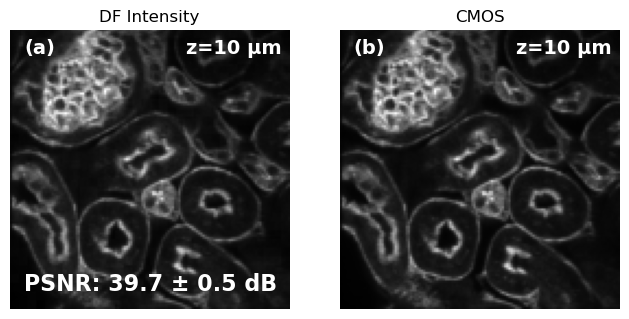

In [24]:
def plot_quantitative_intensity(volume_gt, volume_fused, z_index=10, save_name=None):
    psnr_intensity_mean, psnr_intensity_std = volume_psnr(volume_gt, volume_fused)

    fig = plt.figure(figsize=(6.5, 3.5))
    gs = fig.add_gridspec(1, 2, width_ratios=[1, 1], height_ratios=[1])

    ax = fig.add_subplot(gs[0, 0])
    ax.imshow(volume_fused[z_index], cmap="gray")
    ax.set_title("DF Intensity")
    ax.text(
        0.05, 0.05, f"PSNR: {psnr_intensity_mean:.1f} ± {psnr_intensity_std:.1f} dB",
        transform=ax.transAxes,
        fontsize=16,
        va="bottom",
        ha="left",
        color="white",
        fontweight="bold",
    )
    ax.text(0.05, 0.97, "(a)", transform=ax.transAxes, fontsize=14, fontweight="bold", va="top", color="w")
    ax.text(0.63, 0.97, f"z={z_index} µm", transform=ax.transAxes, fontsize=14, fontweight="bold", va="top", color="w")
    ax.axis("off")

    ax = fig.add_subplot(gs[0, 1])
    ax.imshow(volume_gt[z_index], cmap="gray")
    ax.set_title("CMOS")
    ax.text(0.05, 0.97, "(b)", transform=ax.transAxes, fontsize=14, fontweight="bold", va="top", color="w")
    ax.text(0.63, 0.97, f"z={z_index} µm", transform=ax.transAxes, fontsize=14, fontweight="bold", va="top", color="w")
    ax.axis("off")

    plt.tight_layout()
    if save_name is not None:
        plt.savefig(FIGURES_PATH / save_name, dpi=300)
    plt.show()


fused_intensity = min_max_normalize(deepcopy(x.sum(axis=(0, 1))))
cmos_intensity = min_max_normalize(deepcopy(cmos_out))

plot_quantitative_intensity(
    cmos_intensity, fused_intensity,
    z_index=10, save_name="results_kidney2_quantitative_intensity.pdf"
)

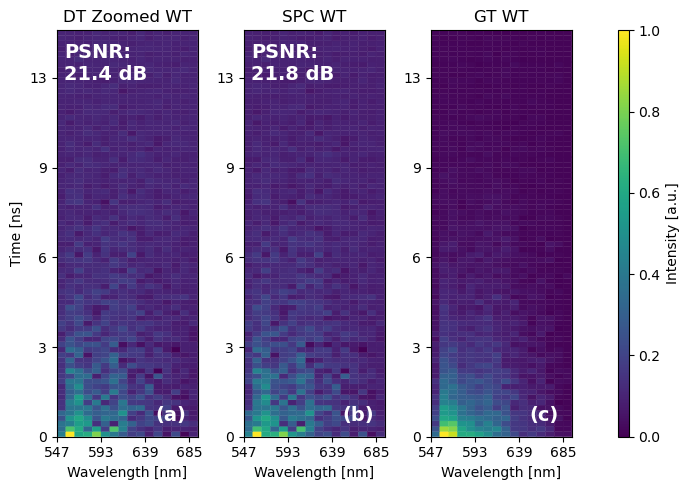

In [27]:
def plot_quantitative_wt_map(wt_gt, wt_fused, wt_spc, save_name=None):
    fig = plt.figure(figsize=(7, 5))
    gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 0.075], height_ratios=[1])

    ax = fig.add_subplot(gs[0, 0])
    ax.pcolor(wt_fused, edgecolors="face")
    ax.set_title("DT Zoomed WT")
    ax.set_ylabel("Time [ns]")
    ax.set_yticks(np.arange(0, len(t), 1)[::17], t.astype(np.int32)[::17])
    ax.set_xlabel("Wavelength [nm]")
    ax.set_xticks(np.arange(0, len(lam), 1)[::5], lam.astype(np.int32)[::5])
    ax.text(
        0.05, 0.97, f"PSNR:\n{psnr(gt_wt, fused_wt, data_range=1.0):.1f} dB",
        transform=ax.transAxes,
        fontsize=14,
        va="top",
        color="white",
        fontweight="bold",
    )
    ax.text(0.7, 0.03, "(a)", transform=ax.transAxes, fontsize=14, fontweight="bold", va="bottom", color="w")


    ax = fig.add_subplot(gs[0, 1])
    ax.pcolor(wt_spc, edgecolors="face")
    ax.set_title("SPC WT")
    # ax.set_ylabel("Time [ns]")
    ax.set_yticks(np.arange(0, len(t), 1)[::17], t.astype(np.int32)[::17])
    ax.set_xlabel("Wavelength [nm]")
    ax.set_xticks(np.arange(0, len(lam), 1)[::5], lam.astype(np.int32)[::5])
    ax.text(
        0.05, 0.97, f"PSNR:\n{psnr(gt_wt, wt_spc, data_range=1.0):.1f} dB",
        transform=ax.transAxes,
        fontsize=14,
        va="top",
        color="white",
        fontweight="bold",
    )
    ax.text(0.7, 0.03, "(b)", transform=ax.transAxes, fontsize=14, fontweight="bold", va="bottom", color="w")


    ax = fig.add_subplot(gs[0, 2])
    ax.pcolor(wt_gt, edgecolors="face")
    ax.set_title("GT WT")
    # ax.set_ylabel("Time [ns]")
    ax.set_yticks(np.arange(0, len(t), 1)[::17], t.astype(np.int32)[::17])
    ax.set_xlabel("Wavelength [nm]")
    ax.set_xticks(np.arange(0, len(lam), 1)[::5], lam.astype(np.int32)[::5])
    ax.text(0.7, 0.03, "(c)", transform=ax.transAxes, fontsize=14, fontweight="bold", va="bottom", color="w")


    fig.colorbar(
        cm.ScalarMappable(norm=None, cmap="viridis"),
        cax=fig.add_subplot(gs[0, 3]), fraction=0.02, pad=0.02,
        orientation="vertical", label="Intensity [a.u.]"
    )

    plt.tight_layout()
    if save_name is not None:
        plt.savefig(FIGURES_PATH / save_name, dpi=300)
    plt.show()


fused_wt = min_max_normalize(deepcopy(x[:, :, :, 48:80, 48:80].sum(axis=(2, 3, 4))))
spc_wt = min_max_normalize(deepcopy(spc_out[:, :, 48 // 4:80 // 4, 48 // 4:80 // 4].sum(axis=(2, 3))))
gt_wt = min_max_normalize(deepcopy(gt_spc.sum(axis=(2, 3))))

plot_quantitative_wt_map(gt_wt, fused_wt, spc_wt, save_name="results_kidney2_quantitative_wt.pdf")

## Plot Z slices in a single figure

In [46]:
def plot_intensity_lambda_lifetime_3(
        intensity_volume, spectral_volume, lifetime_volume,
        t, lam, tau_clip, save_name=None,
):
    fig = plt.figure(figsize=(10, 7))
    gs = fig.add_gridspec(3, 5, width_ratios=[1, 1, 1, 1, 0.05], height_ratios=[1, 1, 1])

    for i, z_index in enumerate([4, 7, 10, 13]):
        # Intensity
        fused_intensity = intensity_volume[z_index]

        # Spectrum
        fused_spectrum = spectral_volume[z_index]
        wavelengths_ticks = np.arange(540, 691, 1)
        spectral_colors = linear_to_srgb(wavelength_to_srgb(wavelengths_ticks, "basic").T)
        spectral_colors /= spectral_colors.max(axis=1)[..., np.newaxis]
        spectral_cmap = LinearSegmentedColormap.from_list("spectrum", spectral_colors, N=len(wavelengths_ticks))

        # Lifetime
        hsv_colormap = np.vstack([np.linspace(0, 26 / 36, 100)[::-1], np.ones(100), np.ones(100)]).T
        lifetime_cmap = LinearSegmentedColormap.from_list("lifetime", hsv_to_rgb(hsv_colormap), N=100)

        # Plot intensity
        ax = fig.add_subplot(gs[0, i])
        ax.imshow(fused_intensity, cmap="gray", vmin=0, vmax=1)
        ax.set_title(f"Depth index: {z_index}")
        ax.set_xticks([])
        ax.set_yticks([])
        if i == 0:
            ax.set_ylabel("Intensity Image", fontsize=13)

        # Plot spectral
        ax = fig.add_subplot(gs[1, i])
        ax.imshow(fused_spectrum, cmap=spectral_cmap)
        ax.set_xticks([])
        ax.set_yticks([])
        if i == 0:
            ax.set_ylabel("Spectral Image", fontsize=13)

        # Plot lifetime
        ax = fig.add_subplot(gs[2, i])
        ax.imshow(lifetime_volume[z_index], cmap=lifetime_cmap)
        ax.set_xticks([])
        ax.set_yticks([])
        if i == 0:
            ax.set_ylabel(f"Lifetime Image", fontsize=13)

    # Colorbars
    fig.colorbar(
        cm.ScalarMappable(norm=None, cmap="gray"),
        cax=fig.add_subplot(gs[0, 4]),
        fraction=0.02, pad=0.01,
        orientation="vertical", label="Intensity [a.u.]")

    cbar = fig.colorbar(
        cm.ScalarMappable(norm=None, cmap=spectral_cmap),
        cax=fig.add_subplot(gs[1, 4]),
        fraction=0.02, pad=0.01,
        orientation="vertical", label="Wavelength [nm]")
    cbar.set_ticks(np.linspace(0, 1, len(wavelengths_ticks[::30])))
    cbar.set_ticklabels([f"{w:.0f}" for w in wavelengths_ticks[::30]])

    cbar = fig.colorbar(
        cm.ScalarMappable(norm=None, cmap=lifetime_cmap),
        cax=fig.add_subplot(gs[2, 4]),
        fraction=0.02, pad=0.01,
        orientation="vertical", label="Lifetime [ns]")
    cbar.set_ticks(np.linspace(0, 1, 6))
    cbar.set_ticklabels([f"{time:.1f}" for time in np.linspace(tau_min, tau_max, 6)])

    plt.tight_layout()
    if save_name is not None:
        plt.savefig(FIGURES_PATH / save_name, dpi=300)
    plt.show()


plot_intensity_lambda_lifetime_3(intensity_volume, spectral_volume, lifetime_volume, t, lam, tau_clip=(1, 4),
                                 save_name="results_across_z.pdf")

NameError: name 'intensity_volume' is not defined

 ## View in 3D

In [ ]:
import pyvista as pv

pv.set_jupyter_backend('static')

pl = pv.Plotter()
_ = pl.add_volume(x.sum(axis=(0, 1)).swapaxes(0, -1), cmap="viridis")
pl.show()